# Assignment: SVD Preprocessing on MNIST with Logistic Regression

## Instructions:
In this assignment, you will apply **Singular Value Decomposition (SVD)** as a preprocessing step to the **MNIST dataset** and train a **logistic regression classifier**. You will compare the model performance and training time when using different levels of SVD for dimensionality reduction.

In this assignment, you will need to:
1. Load the MNIST dataset and normalize it.
2. Perform SVD and reduce the dimensions of the data.
3. Train a logistic regression model on the original and SVD-reduced data.
4. Measure and compare the training time and accuracy of the model with varying SVD components.
5. Plot the results and analyze how SVD impacts the performance and efficiency of the model.

***
Your tasks include:
1. Implement SVD algorithm. You are not allowed to directly use SVD implemented by other packages, but you may use functions in NumPy. (Part 2)
2. Explore the accuracy and time performance from different numbers of SVD components. (Part 4)
3. Visualize the accuracy, time performance and top 5 singular vectors in the dataset, analyze and explain which number of SVD component looks best to you? (Part 4,5&6) Hint: singular vectors should be reshaped to 28x28 images for visualization.
***
**Note that you may not import any other function or package.** Let's get started!


## Part 1: Load the MNIST dataset and preprocess the data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser="auto")
X = mnist.data
y = mnist.target

# Normalize the data
X = X / 255.0
print("x: ", X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading MNIST dataset...
x:         pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

## Part 2: Implement SVD for Dimensionality Reduction

In [4]:
def apply_svd_custom(X_train, X_test, n_components):

    """
    Slow code version 1:
    def apply_svd_custom(X_train, X_test, n_components):
    # Multiply transposes
    V_train, V_test = np.dot(X_train.T, X_train), np.dot(X_test.T, X_test)
    U_train, U_test = np.dot(X_train, X_train.T), np.dot(X_test, X_test.T)

    # Find eigenvalues and eigenvectors
    V_train_eigenvalues, V_train_eigenvectors = np.linalg.eig(V_train)
    V_test_eigenvalues, V_test_eigenvectors = np.linalg.eig(V_test)

    U_train_eigenvalues, U_train_eigenvectors = np.linalg.eig(U_train)
    U_test_eigenvalues, U_test_eigenvectors = np.linalg.eig(U_test)

    # Sort eigenvalues and eigenvectors
    sorted_indices_train, sorted_indices_test = V_train_eigenvalues.argsort()[::-1], V_test_eigenvalues.argsort()[::-1]
    V_train_eigenvalues, V_test_eigenvalues = V_train_eigenvalues[sorted_indices_train], V_test_eigenvalues[sorted_indices_test]
    V_train_eigenvectors, V_test_eigenvectors = V_train_eigenvectors[:, sorted_indices_train], V_test_eigenvectors[:, sorted_indices_test]

    sorted_indices_train, sorted_indices_test = U_train_eigenvalues.argsort()[::-1], U_test_eigenvalues.argsort()[::-1]
    U_train_eigenvalues, U_test_eigenvalues = U_train_eigenvalues[sorted_indices_train], U_test_eigenvalues[sorted_indices_test]
    U_train_eigenvectors, U_test_eigenvectors = U_train_eigenvectors[:, sorted_indices_train], U_test_eigenvectors[:, sorted_indices_test]

    # Find Sqrt of eigenvalues to find singular value
    for index, value in enumerate(V_train_eigenvalues):
        V_train_eigenvalues[index] = np.sqrt(np.abs(value))
    for index, value in enumerate(V_test_eigenvalues):
        V_test_eigenvalues[index] = np.sqrt(np.abs(value))

    # Create Sigma
    sigma_train, sigma_test = np.diag(V_train_eigenvalues), np.diag(V_test_eigenvalues)

    U_train_eigenvectors = U_train_eigenvectors[:, :n_components]
    V_train_eigenvectors = V_train_eigenvectors[:, :n_components]
    sigma_train = sigma_train[:n_components, :]

    U_test_eigenvectors = U_test_eigenvectors[:, :n_components]
    V_test_eigenvectors = V_test_eigenvectors[:, :n_components]
    sigma_test = sigma_test[:n_components, :]

    for row in range(len(U_train_eigenvectors[0])):
        magnitude = np.linalg.norm(U_train_eigenvectors[:, row])
        if np.isnan(magnitude) or magnitude == 0:
            U_train_eigenvectors[:, row] = 0
        else:
            U_train_eigenvectors[:, row] *= (1 / magnitude)

    for row in range(len(U_test_eigenvectors[0])):
        magnitude = np.linalg.norm(U_test_eigenvectors[:, row])
        if np.isnan(magnitude) or magnitude == 0:
            U_test_eigenvectors[:, row] = 0
        else:
            U_test_eigenvectors[:, row] *= (1 / magnitude)

    X_train_reduced = np.dot(U_train_eigenvectors, np.dot(sigma_train, V_train_eigenvectors.T))
    X_test_reduced = np.dot(U_test_eigenvectors, np.dot(sigma_test, V_test_eigenvectors.T))

    return(X_train_reduced, X_test_reduced)


    """

    # Ensure X_train and X_test contain only real values
    X_train = np.real(X_train)
    X_test = np.real(X_test)

    # Compute covariance matrix
    cov_matrix = np.cov(X_train.T)

    # Compute eigenvectors and eigenvalues of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Ensure eigenvalues and eigenvectors are real
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    # Sort eigenvectors in descending order of eigenvalues
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Select top n_components eigenvectors
    eigenvalues_selected = eigenvalues[:n_components]
    eigenvectors_selected = eigenvectors[:, :n_components]

    # Compute U, Σ, and V^T matrices
    U = X_train @ eigenvectors_selected
    Sigma = np.diag(np.sqrt(eigenvalues_selected))
    Vt = eigenvectors_selected

    # Project data onto selected singular vectors
    X_train_svd = U @ Sigma
    X_test_svd = X_test @ Vt

    return X_train_svd, X_test_svd



## Part 3: Train Logistic Regression and Measure Performance

In [5]:
# Function to train logistic regression and track training time
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='saga', random_state=42, multi_class='multinomial')
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time


## Part 4: Experiment with Different Levels of SVD

Now, apply SVD with varying numbers of components and observe how the dimensionality reduction impacts the model's performance. Record both the accuracy and training time for each number of components.


In [6]:
svd_components = [2, 5, 10, 20, 50, 100, 200]  # You need to decide what number to search...

# Store the results
results = []

print("Training models with different levels of SVD preprocessing...")
for n_components in svd_components:
    print(f"Applying custom SVD with {n_components} components...")
    
    # Apply SVD to the training and test sets
    # Call apply_svd_custom() here...
    X_train_svd, X_test_svd = apply_svd_custom(X_train, X_test, n_components)

    # Train the logistic regression model and get accuracy and training time
    accuracy, training_time = train_logistic_regression(X_train_svd, y_train, X_test_svd, y_test)
        
    results.append((n_components, accuracy, training_time))
    
    print(f"SVD components: {n_components}, Accuracy: {accuracy:.4f}, Training time: {training_time:.4f} seconds")

Training models with different levels of SVD preprocessing...
Applying custom SVD with 2 components...
SVD components: 2, Accuracy: 0.3278, Training time: 0.4811 seconds
Applying custom SVD with 5 components...
SVD components: 5, Accuracy: 0.5116, Training time: 0.8912 seconds
Applying custom SVD with 10 components...
SVD components: 10, Accuracy: 0.6996, Training time: 1.4914 seconds
Applying custom SVD with 20 components...
SVD components: 20, Accuracy: 0.7657, Training time: 3.1366 seconds
Applying custom SVD with 50 components...
SVD components: 50, Accuracy: 0.7479, Training time: 47.7703 seconds
Applying custom SVD with 100 components...
SVD components: 100, Accuracy: 0.6782, Training time: 205.8365 seconds
Applying custom SVD with 200 components...
SVD components: 200, Accuracy: 0.6631, Training time: 265.6903 seconds


## Part 5: Visualize and Analyze the Results

Finally, plot the accuracy, training time as a function of the number of SVD components, and top 5 singular vectors. This will help you understand the trade-off between dimensionality reduction, accuracy, and model training time, and how SVD generally works. Hint: singular vectors should be reshaped to 28x28 images for visualization.


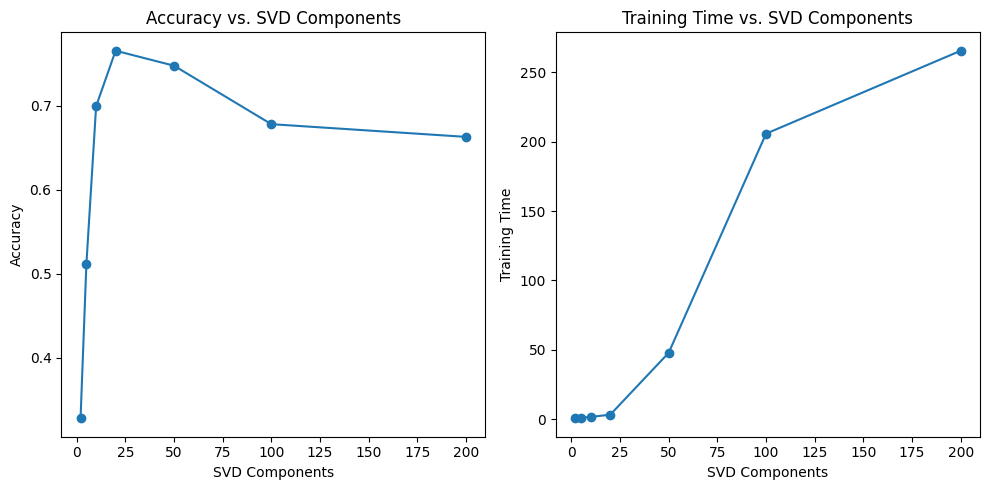

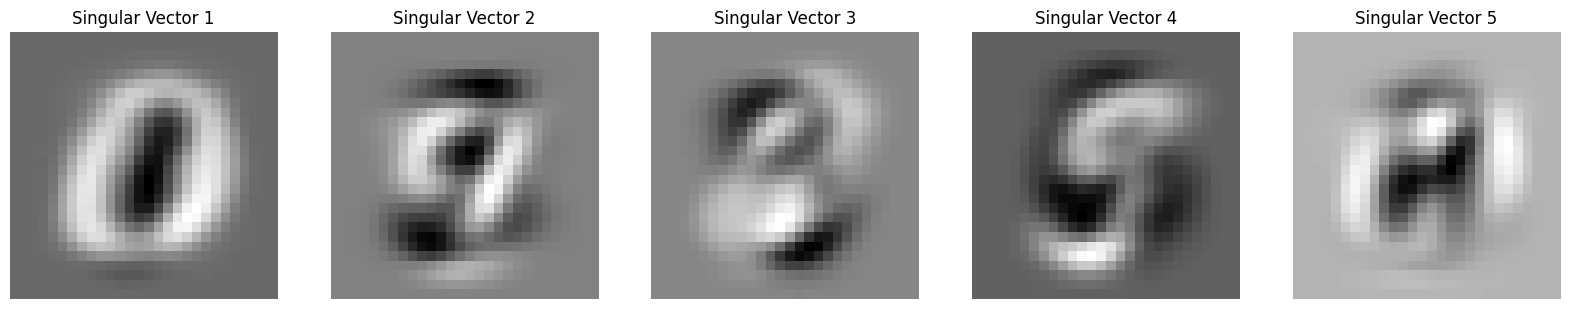

In [9]:
## Your implementation here...
## You may add necessary lines in Part 4 to access data for visualization
svd_components_list, accuracy_list, training_time_list = zip(*results)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(svd_components_list, accuracy_list, marker='o')
plt.title('Accuracy vs. SVD Components')
plt.xlabel('SVD Components')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(svd_components_list, training_time_list, marker='o')
plt.title('Training Time vs. SVD Components')
plt.xlabel('SVD Components')
plt.ylabel('Training Time')

plt.tight_layout()
plt.show()

# Visualize top 5 singular vectors
eigenvalues, eigenvectors = np.linalg.eig(np.cov(X_train.T))
idx = np.argsort(-eigenvalues)
eigenvectors = eigenvectors[:, idx]
top_5_eigenvectors = eigenvectors[:, :5]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    # Convert the eigenvector to its real part before reshaping
    real_singular_vector = np.real(top_5_eigenvectors[:, i]).reshape(28, 28)
    ax.imshow(real_singular_vector, cmap='gray')
    ax.set_title(f'Singular Vector {i+1}')
    ax.axis('off')

plt.show()

## Part 6: Analyze / Conclusion 

YOUR ANSWER: 

In [ ]:
# We find that the accuracy peaks at around 25 components and drops down slowly and the time takes longer the more you increase the number of components